# Environment Set Up

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from jsonParser import JSONParserCOCO
import ipywidgets as widgets
from IPython.display import display

# Loading Data

In [148]:
data_path = "/data/smurfs_coco_format/"
json_file_name = "result.json"
json_file_name = "updated_result.json"

dataset = JSONParserCOCO(data_path, json_file_name)

In [38]:
def update_annot_cat(dataset):
    print("Category Ids:", dataset.categ_dict)
    
    while True:
        ann_id = input("Enter Annotation Id: ")
    
        if not ann_id.isdigit():
            break
            
        cat_id = input("Enter Category Id: ")
    
        if not cat_id.isdigit():
            break
        
        dataset.set_annot_cat_by_id(int(cat_id), int(ann_id))
        dataset.update_json_cat_by_ann_id(int(cat_id), int(ann_id))
        print(f'Annotation ID {ann_id} with new category id {cat_id}')
    
        print("-------------")

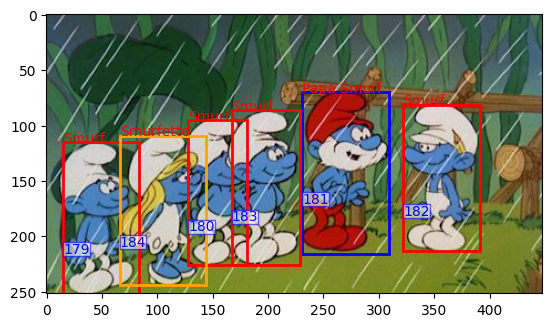

In [149]:
dataset.visualize_annot_by_imgid(41)

In [143]:
update_annot_cat(dataset)

Category Ids: {0: {'id': 0, 'name': 'Smurf'}, 1: {'id': 1, 'name': 'Papa Smurf'}, 2: {'id': 2, 'name': 'Smurfette'}, 3: {'id': 3, 'name': 'Vanity Smurf'}}


Enter Annotation Id:  184
Enter Category Id:  2


Annotation ID 184 with new category id 2
-------------


Enter Annotation Id:  181
Enter Category Id:  1


Annotation ID 181 with new category id 1
-------------


Enter Annotation Id:  


# Training Code